# Imports

In [1]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 415 µs (started: 2023-02-21 18:03:03 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
#import tensorflow as tf
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Concatenate
)
from keras.models import Model
from tensorflow import keras
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.94 s (started: 2023-02-21 18:03:03 +00:00)


In [4]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 2965
ETL_DATASET = 'etl_9G'
DNN_NAME = 'VGG16'
FC_LAYER = 4096

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'regular'

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'/'

print(ROOT_PATH)
print('versión Keras:', keras.__version__) # versión Keras: 2.8.0

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_{}/splits/regular/
versión Keras: 2.11.0
time: 1.36 ms (started: 2023-02-21 18:03:07 +00:00)


In [5]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
time: 1.91 s (started: 2023-02-21 18:03:07 +00:00)


# Funciones

In [6]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored
    - TYPE_IMG: regular o inverted

    Output:
    - np arrays for training and validation images
    '''

    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_9G.npz'
        train_name_labels = 'train_labels_9G.npz'
        val_name_img = 'val_imgs_9G.npz'
        val_name_labels = 'val_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_9G.npz'
        train_name_labels = 'train_inv_labels_9G.npz'
        val_name_img = 'val_inv_imgs_9G.npz'
        val_name_labels = 'val_inv_labels_9G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_9G.npz'
        test_name_labels = 'test_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_9G.npz'
        test_name_labels = 'test_inv_labels_9G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def avg_wts(weights):
    '''
    Function that calculates average of weights along the channel axis
    '''

    #Find mean along the channel axis (second to last axis)
    average_weights = np.mean(
        weights, axis=-2).reshape(weights[:,:,-1:,:].shape
    )  
    return(average_weights)


def configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL):
    vgg_model = keras.applications.VGG16(
        include_top=False, 
        weights='imagenet'
    )

    # Get the dictionary of config for vgg16
    vgg_config = vgg_model.get_config()


    vgg_config["layers"][0]["config"]["batch_input_shape"] = (
        None, HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL
    )

    # Create new model with the updated configuration
    vgg_updated = Model.from_config(vgg_config)

    # Get the configuration for the updated model and extract layer names. 
    # We will use these names to copy over weights from the original model. 
    vgg_updated_config = vgg_updated.get_config()
    vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]

    # Name of the first convolutional layer.
    # Remember that this is the only layer with new additional weights. 
    # All other layers will have same weights as the original model. 
    first_conv_name = vgg_updated_layer_names[1]

    # Update weights for all layers. 
    # And for the first conv layer replace weights with average of all 3 channels. 
    for layer in vgg_model.layers:
        if layer.name in vgg_updated_layer_names:
         

            if layer.get_weights() != []:
                target_layer = vgg_updated.get_layer(layer.name)
        
                if layer.name in first_conv_name:    #For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
              
                    weights_single_channel = avg_wts(weights)
                                                        
                    target_layer.set_weights([weights_single_channel, biases])  #Now set weights for the first conv. layer
                    target_layer.trainable = False   #You can make this trainable if you want. 
        
                else:
                    target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
                    target_layer.trainable = False  #You can make this trainable if you want. 

    return vgg_updated


def create_custom_model(NUM_CLASSES, FC_LAYER):

    # KerasTensor(type_spec=TensorSpec(shape=(None, 2, 2, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
    last_layer = vgg_updated.layers[-1].output

    x = Flatten(name='flatten', input_shape=vgg_updated.output_shape[1:])(last_layer)
    x = Dense(FC_LAYER, activation='relu', name='fc1')(x)
    x = Dense(FC_LAYER, activation='relu', name='fc2')(x)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x) # activation relu??
    custom_model = Model(vgg_updated.inputs, out)

    for layer in custom_model.layers[:-3]: # Hasta aquí llega hasta flatten
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time:")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    '''Recuperar una lista de resultados de la lista de datos de los conjuntos 
    de entrenamiento y pruebas para cada epoch de entrenamiento.
    '''

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER):
    '''Guardar el modelo en disco duro
    
    Args:
        - SIZE: 64, 96, 112 ó 127
        - TFM_PATH = Ruta en drive a la carpeta del TFM
        - custom_model: Modelo de Deep Learning
        - TYPE_IMG: regular o inverted
        - USE_DATA_AUG= sin_DA o con_DA
        - DNN_NAME= Deep Neural Network's name like VGG16 or DenseNet121
        - FC_LAYER: Number of Dense Layer. In this case is 4096
    '''

    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' \
                + TYPE_IMG + f'_FC_{FC_LAYER}.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    custom_model.save(WEIGHTS_PATH) # lo guarda es en el notebook

    print(f'------ Model Saved in {WEIGHTS_PATH}-------')


time: 8.83 ms (started: 2023-02-21 18:03:09 +00:00)


# Imgs 64x64

- Test Accuracy: 0.8117706775665283
- Test Loss: 1.134413242340088
- time: 1h 1min 7s
- F1 score: 0.8127672879836036
- Precision score: 0.8313715615695079
- Recall:  0.81177065767285
- Epoch: 37/50




## Cargar la imágenes

In [7]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_64/splits/regular/
time: 740 µs (started: 2023-02-21 13:57:54 +00:00)


In [8]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 28.6 s (started: 2023-02-21 13:57:54 +00:00)


In [9]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 64, 64, 1) and labels: (444750,)

- val images: (88950, 64, 64, 1) and labels: (88950,)

time: 1.31 ms (started: 2023-02-21 13:58:23 +00:00)


## Preparar el modelo

In [10]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

58889256/58889256 [==============================] - 0s 0us/step
time: 4.87 s (started: 2023-02-21 13:58:23 +00:00)


In [11]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 47.6 ms (started: 2023-02-21 13:58:28 +00:00)


In [12]:
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## Entrenar modelo

In [13]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 110s 7ms/step - loss: 4.6744 - sparse_categorical_accuracy: 0.1408 - val_loss: 3.0815 - val_sparse_categorical_accuracy: 0.3108
Epoch 2/50
13899/13899 [==============================] - 98s 7ms/step - loss: 2.4844 - sparse_categorical_accuracy: 0.4174 - val_loss: 2.0869 - val_sparse_categorical_accuracy: 0.4938
Epoch 3/50
13899/13899 [==============================] - 98s 7ms/step - loss: 1.7647 - sparse_categorical_accuracy: 0.5599 - val_loss: 1.6208 - val_sparse_categorical_accuracy: 0.5947
Epoch 4/50
13899/13899 [==============================] - 99s 7ms/step - loss: 1.3743 - sparse_categorical_accuracy: 0.6463 - val_loss: 1.3291 - val_sparse_categorical_accuracy: 0.6559
Epoch 5/50
13899/13899 [==============================] - 99s 7ms/step - loss: 1.1474 - sparse_categorical_accuracy: 0.6981 - val_loss: 1.1649 - val_sparse_categorical_accuracy: 0.6946
Epoch 6/50
13899/13899 [==============================] - 99s 7ms/step - l

In [14]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 3.6 s (started: 2023-02-21 14:59:35 +00:00)


In [15]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 7s 4ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8117706775665283
- Test Loss: 1.134413242340088
- time:
- F1 score: 0.8127672879836036
- Precision score: 0.8313715615695079
- Recall:  0.81177065767285
- Epoch: 
*********************************************************************************************************************************
time: 20.6 s (started: 2023-02-21 14:59:39 +00:00)


## Graficando

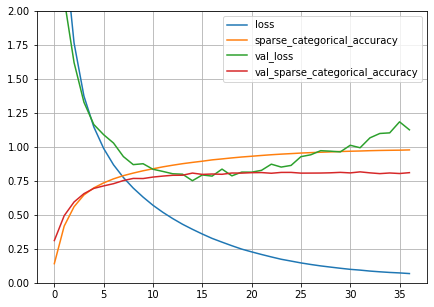

time: 278 ms (started: 2023-02-21 15:00:00 +00:00)


In [16]:
plot_loss(history)

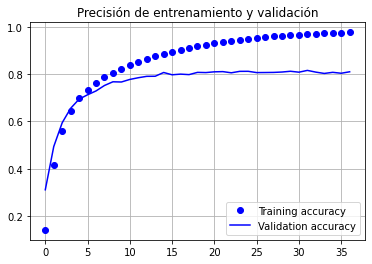

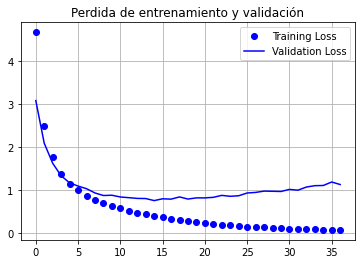

time: 375 ms (started: 2023-02-21 15:00:00 +00:00)


In [17]:
show_history(history)

In [18]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG16/weights_vgg16/sin_DA/regular/model_vgg16_etl9_imgs64_regular_FC_4096.h5-------
time: 1.74 s (started: 2023-02-21 15:00:00 +00:00)


# Imgs 96x96

- Test Accuracy: 0.8864755630493164
- Test Loss: 0.6771373152732849
- time: 1h 3min 35s
- F1 score: 0.8872553053570058
- Precision score: 0.8999101655694876
- Recall:  0.8864755480607083
- Epoch: 31/50


## Cargar las imágenes

In [19]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_96/splits/regular/
time: 727 µs (started: 2023-02-21 15:00:04 +00:00)


In [20]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 56 s (started: 2023-02-21 15:00:04 +00:00)


In [21]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 96, 96, 1) and labels: (444750,)

- val images: (88950, 96, 96, 1) and labels: (88950,)

time: 1.08 ms (started: 2023-02-21 15:01:00 +00:00)


## Preparar el modelo

In [22]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 564 ms (started: 2023-02-21 15:01:00 +00:00)


In [23]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 38.6 ms (started: 2023-02-21 15:01:00 +00:00)


In [24]:
print(custom_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0   

## Entrenar modelo

In [25]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 127s 9ms/step - loss: 3.5093 - sparse_categorical_accuracy: 0.2972 - val_loss: 1.8283 - val_sparse_categorical_accuracy: 0.5344
Epoch 2/50
13899/13899 [==============================] - 122s 9ms/step - loss: 1.3459 - sparse_categorical_accuracy: 0.6439 - val_loss: 1.0831 - val_sparse_categorical_accuracy: 0.7050
Epoch 3/50
13899/13899 [==============================] - 122s 9ms/step - loss: 0.8950 - sparse_categorical_accuracy: 0.7533 - val_loss: 0.8723 - val_sparse_categorical_accuracy: 0.7576
Epoch 4/50
13899/13899 [==============================] - 123s 9ms/step - loss: 0.6700 - sparse_categorical_accuracy: 0.8097 - val_loss: 0.7042 - val_sparse_categorical_accuracy: 0.8037
Epoch 5/50
13899/13899 [==============================] - 122s 9ms/step - loss: 0.5341 - sparse_categorical_accuracy: 0.8466 - val_loss: 0.5975 - val_sparse_categorical_accuracy: 0.8325
Epoch 6/50
13899/13899 [==============================] - 122s 9ms/ste

In [26]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 7.05 s (started: 2023-02-21 16:04:36 +00:00)


In [27]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 9s 5ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8864755630493164
- Test Loss: 0.6771373152732849
- time:
- F1 score: 0.8872553053570058
- Precision score: 0.8999101655694876
- Recall:  0.8864755480607083
- Epoch: 
*********************************************************************************************************************************
time: 25.8 s (started: 2023-02-21 16:04:43 +00:00)


## Graficando

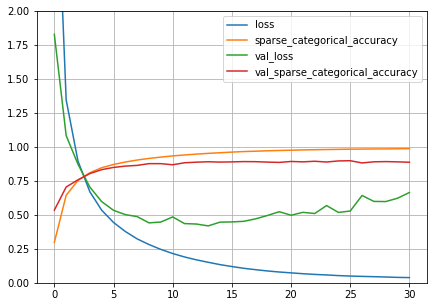

time: 195 ms (started: 2023-02-21 16:05:09 +00:00)


In [28]:
plot_loss(history)

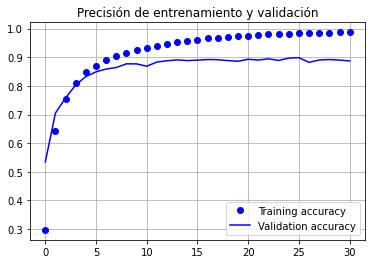

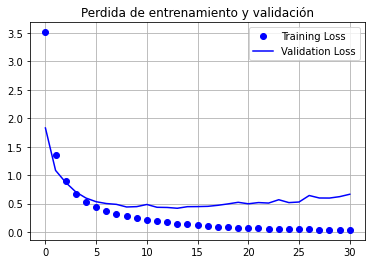

time: 414 ms (started: 2023-02-21 16:05:09 +00:00)


In [29]:
show_history(history)

In [30]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG16/weights_vgg16/sin_DA/regular/model_vgg16_etl9_imgs96_regular_FC_4096.h5-------
time: 1.54 s (started: 2023-02-21 16:05:09 +00:00)


In [31]:
quit()

time: 546 µs (started: 2023-02-21 16:05:12 +00:00)


# Imgs 112x112 

- Test Accuracy: 0.901483952999115
- Test Loss: 0.5593587160110474
- time: 58min 10s
- F1 score: 0.9018101184870949
- Precision score: 0.9120352149604758
- Recall:  0.9014839797639123
- Epoch: 26/50


## Cargar imágenes

In [8]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_112/splits/regular/
time: 1.14 ms (started: 2023-02-21 16:07:35 +00:00)


In [9]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 1min 16s (started: 2023-02-21 16:07:35 +00:00)


In [10]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 112, 112, 1) and labels: (444750,)

- val images: (88950, 112, 112, 1) and labels: (88950,)

time: 1.08 ms (started: 2023-02-21 16:08:51 +00:00)


## Preparar el modelo

In [11]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 2.24 s (started: 2023-02-21 16:08:51 +00:00)


In [12]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 45.2 ms (started: 2023-02-21 16:08:53 +00:00)


In [13]:
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 112, 112, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 56, 56, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 28, 28, 128)       0     

## Entrenar modelo


In [14]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 141s 10ms/step - loss: 2.8580 - sparse_categorical_accuracy: 0.4119 - val_loss: 1.2666 - val_sparse_categorical_accuracy: 0.6607
Epoch 2/50
13899/13899 [==============================] - 132s 10ms/step - loss: 0.9424 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.7702 - val_sparse_categorical_accuracy: 0.7861
Epoch 3/50
13899/13899 [==============================] - 132s 10ms/step - loss: 0.6130 - sparse_categorical_accuracy: 0.8257 - val_loss: 0.5896 - val_sparse_categorical_accuracy: 0.8331
Epoch 4/50
13899/13899 [==============================] - 133s 10ms/step - loss: 0.4539 - sparse_categorical_accuracy: 0.8681 - val_loss: 0.5248 - val_sparse_categorical_accuracy: 0.8506
Epoch 5/50
13899/13899 [==============================] - 132s 10ms/step - loss: 0.3574 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.4713 - val_sparse_categorical_accuracy: 0.8658
Epoch 6/50
13899/13899 [==============================] - 133s 10

## Graficando

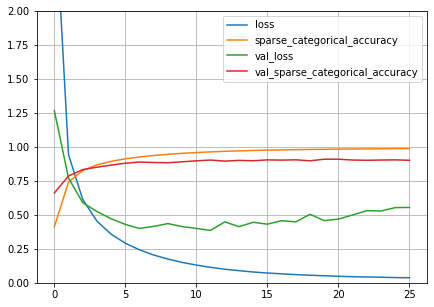

time: 279 ms (started: 2023-02-21 17:07:04 +00:00)


In [15]:
plot_loss(history)

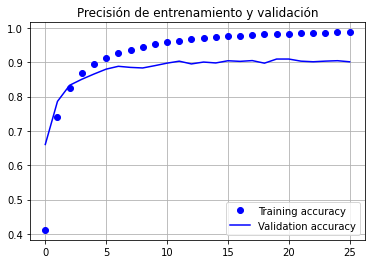

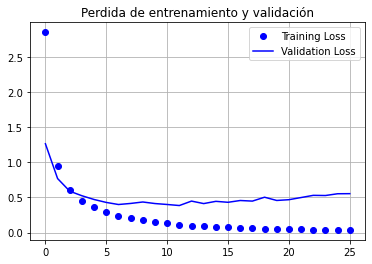

time: 374 ms (started: 2023-02-21 17:07:04 +00:00)


In [16]:
show_history(history)

In [17]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG16/weights_vgg16/sin_DA/regular/model_vgg16_etl9_imgs112_regular_FC_4096.h5-------
time: 1.52 s (started: 2023-02-21 17:07:05 +00:00)


## Métricas

In [18]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 8.73 s (started: 2023-02-21 17:07:06 +00:00)


In [19]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 10s 5ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.901483952999115
- Test Loss: 0.5593587160110474
- time:
- F1 score: 0.9018101184870949
- Precision score: 0.9120352149604758
- Recall:  0.9014839797639123
- Epoch: 
*********************************************************************************************************************************
time: 31.5 s (started: 2023-02-21 17:07:15 +00:00)


In [20]:
quit()

time: 411 µs (started: 2023-02-21 17:07:46 +00:00)


# Imgs 127x127

- Test Accuracy: 0.904536247253418
- Test Loss: 0.4890071153640747
- time: 50min 10s
- F1 score: 0.9050376648744786
- Precision score: 0.913371169313885
- Recall:  0.9045362563237774
- Epoch: 21/50





## Cargar imágenes

Usa splits/regular_v2/

In [8]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE

ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'_v2/'
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_127/splits/regular_v2/
time: 1.22 ms (started: 2023-02-21 18:03:25 +00:00)


In [9]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 1min 26s (started: 2023-02-21 17:09:51 +00:00)


In [10]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (355800, 127, 127, 1) and labels: (355800,)

- val images: (118600, 127, 127, 1) and labels: (118600,)

time: 894 µs (started: 2023-02-21 17:11:17 +00:00)


## Preparar el modelo

In [11]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 2.25 s (started: 2023-02-21 17:11:17 +00:00)


In [12]:
custom_model = create_custom_model(NUM_CLASSES, FC_LAYER)

time: 44.5 ms (started: 2023-02-21 17:11:19 +00:00)


In [13]:
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 127, 127, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 127, 127, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 127, 127, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 63, 63, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 63, 63, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 63, 63, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 31, 31, 128)       0     

## Entrenar modelo

In [14]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
11119/11119 [==============================] - 153s 13ms/step - loss: 2.8810 - sparse_categorical_accuracy: 0.4152 - val_loss: 1.2429 - val_sparse_categorical_accuracy: 0.6680
Epoch 2/50
11119/11119 [==============================] - 141s 13ms/step - loss: 0.8819 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.7519 - val_sparse_categorical_accuracy: 0.7891
Epoch 3/50
11119/11119 [==============================] - 141s 13ms/step - loss: 0.5655 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.5993 - val_sparse_categorical_accuracy: 0.8304
Epoch 4/50
11119/11119 [==============================] - 141s 13ms/step - loss: 0.4125 - sparse_categorical_accuracy: 0.8785 - val_loss: 0.5113 - val_sparse_categorical_accuracy: 0.8537
Epoch 5/50
11119/11119 [==============================] - 143s 13ms/step - loss: 0.3212 - sparse_categorical_accuracy: 0.9036 - val_loss: 0.4903 - val_sparse_categorical_accuracy: 0.8631
Epoch 6/50
11119/11119 [==============================] - 142s 13

## Graficando

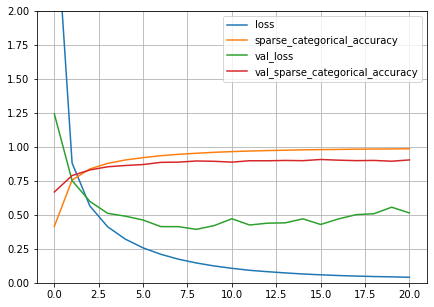

time: 259 ms (started: 2023-02-21 18:01:30 +00:00)


In [15]:
plot_loss(history)

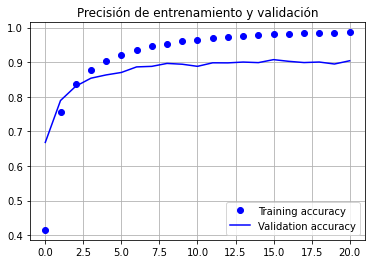

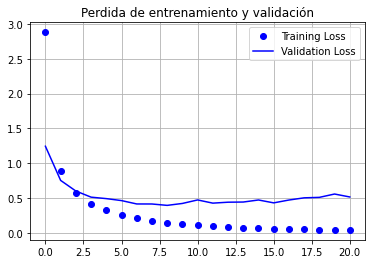

time: 412 ms (started: 2023-02-21 18:01:30 +00:00)


In [16]:
show_history(history)

In [17]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved in /content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG16/weights_vgg16/sin_DA/regular/model_vgg16_etl9_imgs127_regular_FC_4096.h5-------
time: 1.48 s (started: 2023-02-21 18:01:31 +00:00)


In [ ]:
quit()

## Métricas

In [9]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 21.6 s (started: 2023-02-21 18:03:33 +00:00)


In [10]:
# cargar modelo?

MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' + TYPE_IMG +'.h5'
WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME


print(WEIGHTS_PATH)

custom_model = keras.models.load_model(WEIGHTS_PATH)

/content/gdrive/MyDrive/Master_IA/TFM/notebooks/arqs_2023/VGG16/weights_vgg16/sin_DA/regular/model_vgg16_etl9_imgs127_regular.h5
time: 2.99 s (started: 2023-02-21 18:03:54 +00:00)


In [11]:
show_metrics(custom_model, test_images, test_labels)

3707/3707 [==============================] - 25s 7ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.904536247253418
- Test Loss: 0.4890071153640747
- time:
- F1 score: 0.9050376648744786
- Precision score: 0.913371169313885
- Recall:  0.9045362563237774
- Epoch: 
*********************************************************************************************************************************
time: 1min 21s (started: 2023-02-21 18:03:57 +00:00)


In [12]:
runtime.unassign()

time: 198 ms (started: 2023-02-21 18:05:45 +00:00)
